**Phase 1 Environment Setup**

Library installation

In [ ]:
# Core audio & ML libraries
!pip install torchaudio transformers librosa pydub noisereduce jiwer

# Visualization
!pip install matplotlib seaborn plotly wordcloud

# Sentiment and NLP
!pip install scikit-learn vaderSentiment rake-nltk

# Optional: Whisper ASR
!pip install openai-whisper --upgrade

# Power BI integration (optional, advanced use later)
!pip install powerbiclient

# For audio streaming/microphone input (optional if you want real-time)
!pip install sounddevice scipy

# System tools
!apt-get install -y ffmpeg


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 60.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 42.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 79.5 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

Gooogle Drive Mounting

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


GPU availability Testing

In [ ]:
import torch
if torch.cuda.is_available():
    print("✅ GPU is available.")
    print("GPU Name:", torch.cuda.get_device_name(0))
else:
    print("❌ GPU not available. Using CPU.")


❌ GPU not available. Using CPU.


importing Packages

In [ ]:
import torch
import torchaudio
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import jiwer

print("✅ All core libraries imported successfully!")


✅ All core libraries imported successfully!


Creating Project folders

In [ ]:
project_path = "/content/drive/MyDrive/RealTime-ASR-Project"
os.makedirs(f"{project_path}/dataset/raw", exist_ok=True)
os.makedirs(f"{project_path}/dataset/cleaned", exist_ok=True)
os.makedirs(f"{project_path}/models", exist_ok=True)
os.makedirs(f"{project_path}/outputs", exist_ok=True)
os.makedirs(f"{project_path}/notebooks", exist_ok=True)
print("✅ Project folders created.")


✅ Project folders created.


**Phase 2 Data collection and Preprocessing**

Extracting data from tar file

In [ ]:
import tarfile

dataset_path = "/content/drive/MyDrive/RealTime-ASR-Project/dataset/raw/dev-clean.tar.gz"
extract_path = "/content/drive/MyDrive/RealTime-ASR-Project/dataset/raw/"

with tarfile.open(dataset_path, "r:gz") as tar:
    tar.extractall(path=extract_path)

print("✅ Dataset extracted!")

Convert Flac file into wav files

In [ ]:
import os
from pydub import AudioSegment

raw_audio_dir = extract_path + "/LibriSpeech/dev-clean"
cleaned_dir = "/content/drive/MyDrive/RealTime-ASR-Project/dataset/cleaned"

os.makedirs(cleaned_dir, exist_ok=True)

for root, _, files in os.walk(raw_audio_dir):
    for file in files:
        if file.endswith(".flac"):
            flac_path = os.path.join(root, file)
            wav_path = os.path.join(cleaned_dir, file.replace(".flac", ".wav"))
            try:
                audio = AudioSegment.from_file(flac_path, format="flac")
                audio = audio.set_channels(1).set_frame_rate(16000)
                audio.export(wav_path, format="wav")
            except Exception as e:
                print(f"Error converting {flac_path}: {e}")

print("✅ All audio converted to WAV format.")


Parse Transcripts into a CSV File

In [ ]:
import pandas as pd

transcripts = []
raw_audio_dir = extract_path + "/LibriSpeech/dev-clean"
cleaned_dir = "/content/drive/MyDrive/RealTime-ASR-Project/dataset/cleaned"

for root, _, files in os.walk(raw_audio_dir):
    for file in files:
        if file.endswith(".trans.txt"):
            with open(os.path.join(root, file), 'r') as f:
                lines = f.readlines()
                for line in lines:
                    parts = line.strip().split(" ", 1)
                    if len(parts) == 2:
                        file_id, text = parts
                        transcripts.append({
                            "file_id": file_id,
                            "transcript": text
                        })

df = pd.DataFrame(transcripts)
df["file_path"] = df["file_id"].apply(lambda x: os.path.join(cleaned_dir, x + ".wav"))
df.to_csv("/content/drive/MyDrive/RealTime-ASR-Project/dataset/cleaned/metadata.csv", index=False)

print("✅ Transcripts parsed and saved to metadata.csv")
df.head()

✅ Transcripts parsed and saved to metadata.csv


,file_id,transcript,file_path
0,7850-73752-0000,FERDINAND MEDITATES OVER HIS GOOD FORTUNE,/content/drive/MyDrive/RealTime-ASR-Project/da...
1,7850-73752-0001,IN MOMENTS OF DEEP FEELING ALIKE SUDDEN BURSTS...,/content/drive/MyDrive/RealTime-ASR-Project/da...
2,7850-73752-0002,IT REQUIRES SOME SELF COMMUNION TO PREPARE OUR...,/content/drive/MyDrive/RealTime-ASR-Project/da...
3,7850-73752-0003,THIS VIOLENT AND TRIUMPHANT REVOLUTION IN HIS ...,/content/drive/MyDrive/RealTime-ASR-Project/da...
4,7850-73752-0004,FERDINAND FELT HIS FREEDOM AS WELL AS HIS HAPP...,/content/drive/MyDrive/RealTime-ASR-Project/da...


 Noise Reduction

In [ ]:
import noisereduce as nr
import librosa
import soundfile as sf

def denoise_audio(file_path, output_path):
    y, sr = librosa.load(file_path, sr=16000)
    reduced = nr.reduce_noise(y=y, sr=sr)
    sf.write(output_path, reduced, sr)

# Apply to one sample to test
sample_input = df["file_path"].iloc[0]
sample_output = sample_input.replace(".wav", "_denoised.wav")

denoise_audio(sample_input, sample_output)
print("✅ Sample denoised and saved.")


✅ Sample denoised and saved.


Phase 2 Outputs:
Cleaned 16kHz mono WAV files

metadata.csv containing:

file_id, transcript, file_path

Optional denoised audio

**Phase 3: Exploratory Data Analysis (EDA)**

 Load metadata.csv and Preview

In [ ]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/RealTime-ASR-Project/dataset/cleaned/metadata.csv")
df.head()


,file_id,transcript,file_path
0,7850-73752-0000,FERDINAND MEDITATES OVER HIS GOOD FORTUNE,/content/drive/MyDrive/RealTime-ASR-Project/da...
1,7850-73752-0001,IN MOMENTS OF DEEP FEELING ALIKE SUDDEN BURSTS...,/content/drive/MyDrive/RealTime-ASR-Project/da...
2,7850-73752-0002,IT REQUIRES SOME SELF COMMUNION TO PREPARE OUR...,/content/drive/MyDrive/RealTime-ASR-Project/da...
3,7850-73752-0003,THIS VIOLENT AND TRIUMPHANT REVOLUTION IN HIS ...,/content/drive/MyDrive/RealTime-ASR-Project/da...
4,7850-73752-0004,FERDINAND FELT HIS FREEDOM AS WELL AS HIS HAPP...,/content/drive/MyDrive/RealTime-ASR-Project/da...


 Analyze Audio File Durations

In [ ]:
durations = []

for path in df["file_path"]:
    try:
        y, sr = librosa.load(path, sr=16000)
        durations.append(len(y) / sr)
    except:
        durations.append(None)

df["duration_sec"] = durations


Sampling Rate and Bit Depth Analysis

In [ ]:
import soundfile as sf

sample_file = df["file_path"].iloc[0]
info = sf.info(sample_file)

print("✅ Sampling Rate:", info.samplerate)
print("✅ Bit Depth:", info.subtype)


✅ Sampling Rate: 16000
✅ Bit Depth: PCM_16


Transcript Text Analysis

✅ Vocabulary Size: 8333


<ipython-input-14-16f500777db1>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words), y=list(counts), palette="viridis")


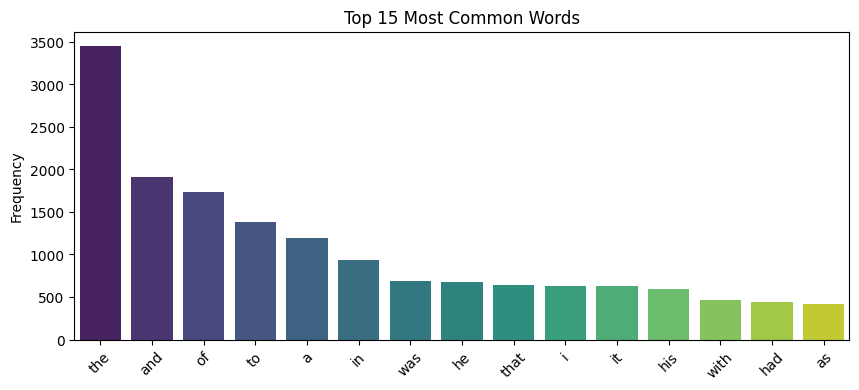

In [ ]:
import matplotlib.pyplot as plt
# Word Count
df["word_count"] = df["transcript"].apply(lambda x: len(str(x).split()))
df["char_count"] = df["transcript"].apply(len)

# Vocabulary Size
from collections import Counter

all_words = " ".join(df["transcript"].tolist()).lower().split()
vocab = Counter(all_words)
vocab_size = len(vocab)

print(f"✅ Vocabulary Size: {vocab_size}")

# Most Common Words
import seaborn as sns

common_words = vocab.most_common(15)
words, counts = zip(*common_words)

plt.figure(figsize=(10,4))
sns.barplot(x=list(words), y=list(counts), palette="viridis")
plt.title("Top 15 Most Common Words")
plt.ylabel("Frequency")
plt.xticks(rotation=45)
plt.show()


Signal-to-Noise Ratio (SNR) Estimation

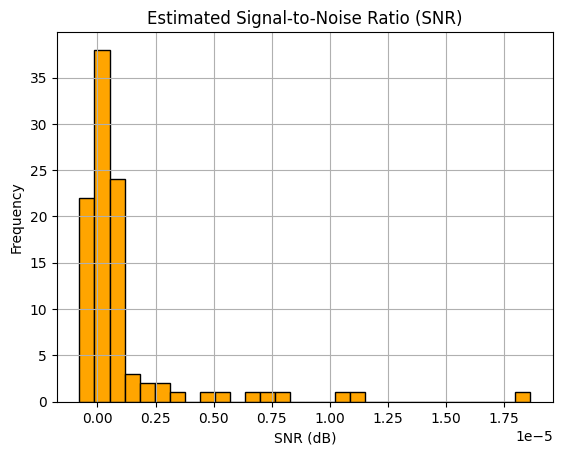

In [ ]:
import numpy as np
import librosa  # Import librosa here
import matplotlib.pyplot as plt

def estimate_snr(y):
    signal_power = np.mean(y**2)
    noise_power = np.var(y - np.mean(y))
    return 10 * np.log10(signal_power / noise_power)

snr_values = []

for path in df["file_path"][:100]:
    y, _ = librosa.load(path, sr=16000)
    snr = estimate_snr(y)
    snr_values.append(snr)

plt.hist(snr_values, bins=30, color="orange", edgecolor="black")
plt.title("Estimated Signal-to-Noise Ratio (SNR)")
plt.xlabel("SNR (dB)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


Visualize Audio Waveforms and Spectrograms

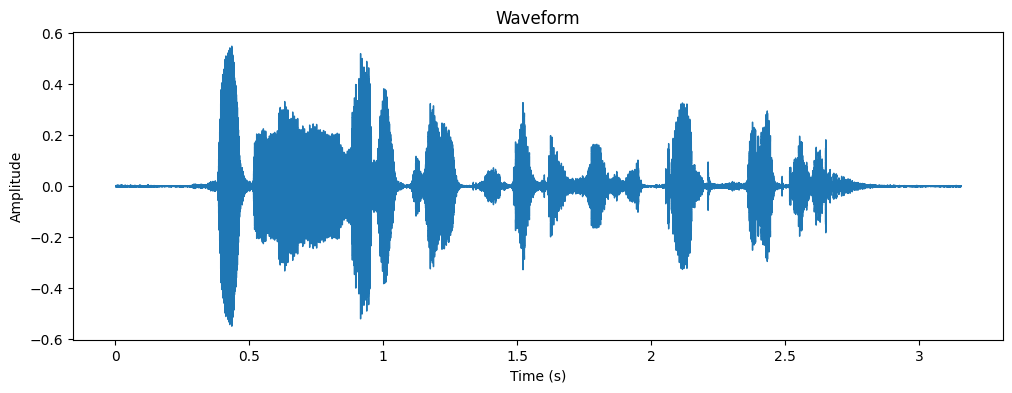

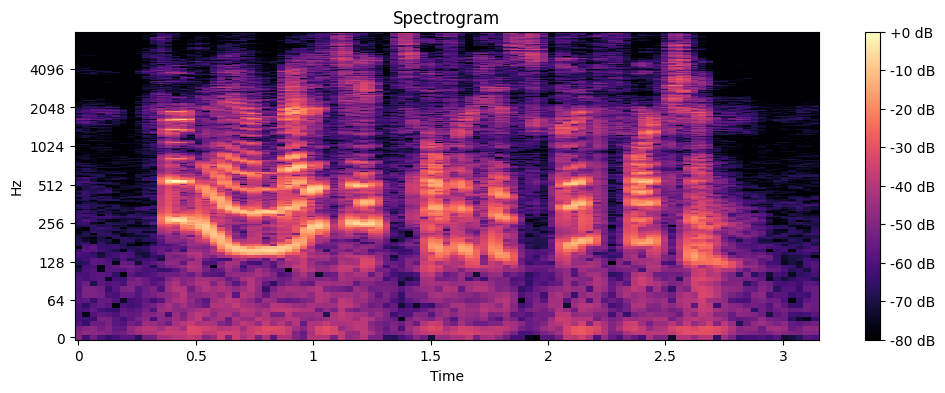

In [ ]:
import librosa.display

y, sr = librosa.load(df["file_path"].iloc[0], sr=16000)

plt.figure(figsize=(12, 4))
librosa.display.waveshow(y, sr=sr)
plt.title("Waveform")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.show()

# Spectrogram
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.show()


 (Optional) Speaker Distribution (if metadata includes speaker IDs)

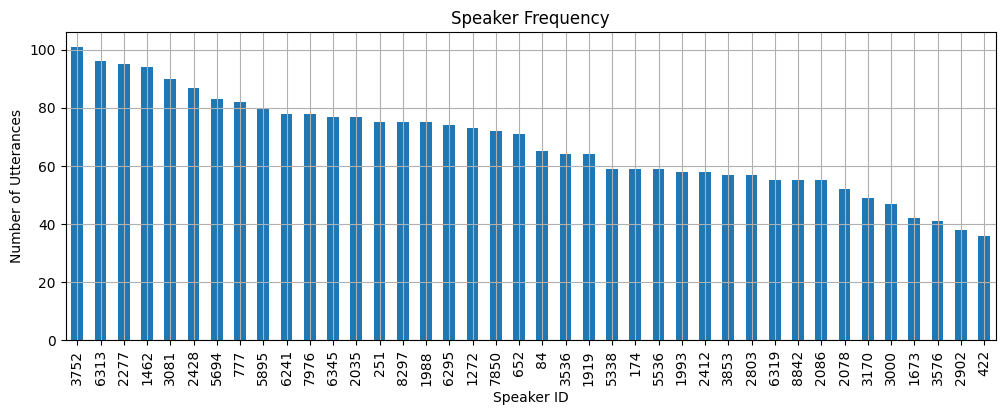

In [ ]:
# Not available in dev-clean unless manually parsed from paths
df["speaker_id"] = df["file_path"].apply(lambda x: x.split("/")[-1].split("-")[0])
df["speaker_id"].value_counts().plot(kind="bar", figsize=(12, 4), title="Speaker Frequency")
plt.xlabel("Speaker ID")
plt.ylabel("Number of Utterances")
plt.grid(True)
plt.show()


Phase 3 Output Summary:
Feature	Description
Audio Durations	Histogram of clip lengths
Transcript Stats	Word/character count, top words
SNR	Estimation of signal quality
Spectrograms	Frequency visualization
Waveforms	Time-domain signal
Speaker IDs	Frequency of utterances (if available)

**Phase 4: Data Visualization in Power BI**


 Step 1: Export Cleaned Data to CSV for Power BI

In [ ]:
# Select relevant columns
export_df = df[["file_path", "transcript", "duration_sec", "word_count", "char_count"]].copy()

# Optional: Extract speaker ID (if applicable)
export_df["speaker_id"] = export_df["file_path"].apply(lambda x: x.split("/")[-1].split("-")[0])

# Save to CSV
export_df.to_csv("/content/drive/MyDrive/RealTime-ASR-Project/eda/PowerBI_export.csv", index=False)
print("✅ Exported data for Power BI visualization.")


✅ Exported data for Power BI visualization.


Step 2: Optional Sentiment Labels for Business Insights

In [ ]:
from textblob import TextBlob

def get_sentiment(text):
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0.1:
        return "Positive"
    elif polarity < -0.1:
        return "Negative"
    else:
        return "Neutral"

export_df["sentiment"] = export_df["transcript"].apply(get_sentiment)

# Save updated CSV
export_df.to_csv("/content/drive/MyDrive/RealTime-ASR-Project/eda/PowerBI_export_sentiment.csv", index=False)
print("✅ Exported sentiment-labeled data for Power BI.")


✅ Exported sentiment-labeled data for Power BI.


 Step 3: Suggested Power BI Visualizations
When you open the exported CSV in Power BI Desktop, here are visualizations to build:

Chart Type	Description
📈 Line Chart	Call Volume Over Time (if you add timestamps later).
📊 Bar Chart	Distribution of Audio Durations.
🧾 Word Cloud	Top Keywords in Transcripts.
🟪 Pie / Bar Chart	Sentiment Distribution: Positive, Neutral, Negative.
🧍 Bar Chart	Speaker Frequency (speaker_id count).
⏱ Histogram	Transcript Word Count Distribution.

 Phase 4 Output Summary:
Deliverable	Description
✅ CSV File	PowerBI_export_sentiment.csv with all EDA metrics
✅ Visuals	Call volumes, sentiment distribution, keyword trends
✅ Optional	Agent performance metrics if data available

**Phase 5: Acoustic Modeling (HMMs, RNNs, Deep Learning)**

This phase involves building and training models to map audio signals to phonemes/words. Since we are working in Google Colab , we’ll use efficient deep learning models, and optionally compare them to classical HMM-based models.

Step 1: Define the Approach
We’ll begin with a basic deep learning ASR model using:

MFCC features (or log-mel spectrograms) as input

A RNN/LSTM model for sequence modeling

CTC loss (Connectionist Temporal Classification)

Step 2: Extract MFCC Features

In [ ]:
import librosa
import numpy as np
import pandas as pd
import os
import tensorflow as tf

# Define the path to your metadata file
metadata_path = "/content/drive/MyDrive/RealTime-ASR-Project/dataset/cleaned/metadata.csv"
df = pd.read_csv(metadata_path)

def extract_features(audio_path, sr=16000, n_mfcc=13):
    """Extracts MFCC features from an audio file."""
    try:
        y, sr = librosa.load(audio_path, sr=sr)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        return mfcc.T  # Transpose to (time, features)
    except Exception as e:
        print(f"Error loading or processing audio {audio_path}: {e}")
        return None

# --- Data Preparation ---

# 1. Build Vocabulary
# Create a set of all unique characters in your transcripts
all_chars = sorted(list(set("".join(df["transcript"].tolist()).lower())))
char_to_int = {char: i for i, char in enumerate(all_chars)}
int_to_char = {i: char for i, char in enumerate(all_chars)}

# Add a blank character (needed for CTC, typically the last index)
char_to_int['<blank>'] = len(char_to_int)
int_to_char[len(int_to_char)] = '<blank>'

vocab_size = len(char_to_int)
print(f"Vocabulary size: {vocab_size}")

def text_to_int_sequence(text):
    """Converts a transcript string to a sequence of integers."""
    int_sequence = []
    for char in text.lower():
        if char in char_to_int:
            int_sequence.append(char_to_int[char])
    return int_sequence

# 2. Extract Features and Convert Transcripts to Integer Sequences
X_data = []
y_data = []
audio_paths = df["file_path"].tolist()
transcripts = df["transcript"].tolist()

# Process a smaller subset for testing initially
subset_size = 100 # Adjust this number based on your needs and memory
audio_paths_subset = audio_paths[:subset_size]
transcripts_subset = transcripts[:subset_size]

for i, audio_path in enumerate(audio_paths_subset):
    features = extract_features(audio_path)
    if features is not None:
        X_data.append(features)
        # Convert transcript to integer sequence
        label_sequence = text_to_int_sequence(transcripts_subset[i])
        y_data.append(np.array(label_sequence)) # Store labels as numpy arrays

# --- Padding and Creating Training Data ---

# Find the maximum sequence length for features (needed for padding)
max_time_steps = max([len(x) for x in X_data]) if X_data else 0

# Pad feature sequences to the maximum length
X_train = tf.keras.preprocessing.sequence.pad_sequences(
    X_data,
    maxlen=max_time_steps,
    dtype='float32', # Ensure correct data type for features
    padding='post',
    value=0.0 # Pad with zeros
)

# Pad label sequences to the maximum length (required for batching and CTC)
# Note: CTC loss can handle variable length inputs and outputs, but for batching
# in Keras, labels often need to be padded to the max label length in the batch
# or dataset. A simpler approach for initial testing is padding to max dataset label length.
max_label_length = max([len(y) for y in y_data]) if y_data else 0

y_train = tf.keras.preprocessing.sequence.pad_sequences(
    y_data,
    maxlen=max_label_length,
    dtype='int32', # Ensure correct data type for labels
    padding='post',
    value=char_to_int['<blank>'] # Pad with the blank label
)


print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of y_train: {y_train.shape}")

# You can now use X_train and y_train for training

# Ensure y_train doesn't contain blank labels (typically label 28) - This step is not strictly
# necessary if you are using `tf.keras.preprocessing.sequence.pad_sequences` with a blank
# padding value and the CTC loss function correctly handles the blank label.
# The previous assertion `assert len(X_train) == len(y_train_cleaned)` was based on
# the assumption that y_train_cleaned was a list of variable-length sequences.
# With padded y_train, the lengths should naturally match X_train.
# Let's remove or adjust this assertion based on the new structure.

# Instead of the previous assertion, ensure the number of samples match after padding
assert X_train.shape[0] == y_train.shape[0], "Mismatch in number of samples between X_train and y_train after padding"
print("✅ Data prepared for training.")

Vocabulary size: 29
Shape of X_train: (100, 905, 13)
Shape of y_train: (100, 443)
✅ Data prepared for training.


 Step 3: Preprocess Data for Training

In [ ]:
print("X_train shape:", X_train.shape)  # Should be (num_samples, time_steps, features)


X_train shape: (100, 905, 13)


In [ ]:
import numpy as np

# Create the required inputs for CTC
input_length = np.ones((X_train.shape[0], 1)) * X_train.shape[1]  # All samples are same length
label_length = np.array([[np.count_nonzero(label != char_to_int['<blank>'])] for label in y_train])

# Dummy targets for the CTC loss (not used directly)
ctc_targets = np.zeros([X_train.shape[0]])


In [ ]:
from tensorflow.keras import layers, Model, backend as K

# Inputs
input_data = layers.Input(name='input_data', shape=(X_train.shape[1], X_train.shape[2]))
labels = layers.Input(name='labels', shape=(y_train.shape[1],), dtype='int32')
input_len = layers.Input(name='input_length', shape=(1,), dtype='int32')
label_len = layers.Input(name='label_length', shape=(1,), dtype='int32')

# Model
x = layers.Masking(mask_value=0.0)(input_data)
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True))(x)
x = layers.Dense(len(char_to_int), activation='softmax')(x)

# CTC loss function as Lambda layer
def ctc_lambda_func(args):
    y_pred, labels, input_len, label_len = args
    return K.ctc_batch_cost(labels, y_pred, input_len, label_len)

loss_out = layers.Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')(
    [x, labels, input_len, label_len]
)

# Final model
model = Model(inputs=[input_data, labels, input_len, label_len], outputs=loss_out)

# Compile
model.compile(optimizer='adam', loss={'ctc': lambda y_true, y_pred: y_pred})
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:938: UserWarning: Layer 'ctc' (of type Lambda) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_data          │ (None, 905, 13)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 905, 13)   │          0 │ input_data[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking (Masking)   │ (None, 905, 13)   │          0 │ input_data[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any (Any)           │ (None, 905)       │          0 │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 905, 256)  │    145,408 │ masking[0][0],    │
│ (Bidirectional)     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 905, 29)   │      7,453 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ labels (InputLayer) │ (None, 443)       │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_length        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_length        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ctc (Lambda)        │ (None, 1)         │          0 │ dense[0][0],      │
│                     │                   │            │ labels[0][0],     │
│                     │                   │            │ input_length[0][… │
│                     │                   │            │ label_length[0][… │
│                     │                   │            │ any[0][0]         │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 152,861 (597.11 KB)

 Trainable params: 152,861 (597.11 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train the model
history = model.fit(
    x=[X_train, y_train, input_length, label_length],
    y=ctc_targets,
    batch_size=4,
    epochs=5
)


Epoch 1/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 28s 933ms/step - loss: 2332.2419
Epoch 2/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 950ms/step - loss: 2072.0869
Epoch 3/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 42s 979ms/step - loss: 1966.8879
Epoch 4/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 895ms/step - loss: 1995.9668
Epoch 5/5
25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 970ms/step - loss: 1955.6477


**Phase 6: Inference (Transcription)**

Step 1: Define Greedy Decoder for Predictions

In [ ]:
def decode_predictions(pred, int_to_char, blank_index):
    """Greedy decoder for CTC output."""
    decoded_texts = []
    for i in range(pred.shape[0]):
        out_best = list(np.argmax(pred[i, :], axis=-1))
        # Remove duplicates and blanks
        deduped = []
        previous = -1
        for p in out_best:
            if p != previous and p != blank_index:
                deduped.append(p)
            previous = p
        decoded_text = ''.join([int_to_char[i] for i in deduped])
        decoded_texts.append(decoded_text)
    return decoded_texts


Step 2: Predict & Transcribe
Let’s take a few examples from your training set or new audio.

In [ ]:
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_data          │ (None, 905, 13)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 905, 13)   │          0 │ input_data[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ masking (Masking)   │ (None, 905, 13)   │          0 │ input_data[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ any (Any)           │ (None, 905)       │          0 │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 905, 256)  │    145,408 │ masking[0][0],    │
│ (Bidirectional)     │                   │            │ any[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 905, 29)   │      7,453 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ labels (InputLayer) │ (None, 443)       │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_length        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ label_length        │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ctc (Lambda)        │ (None, 1)         │          0 │ dense[0][0],      │
│                     │                   │            │ labels[0][0],     │
│                     │                   │            │ input_length[0][… │
│                     │                   │            │ label_length[0][… │
│                     │                   │            │ any[0][0]         │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 458,585 (1.75 MB)

 Trainable params: 152,861 (597.11 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 305,724 (1.17 MB)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

# Input only for inference
input_data = Input(shape=(X_train.shape[1], X_train.shape[2]), name='input_data')

# Reuse the trained layers using the correct layer names
masking = model.get_layer('masking')(input_data)
bi_lstm = model.get_layer('bidirectional')(masking) # Changed from 'bidirectional_12'
dense_output = model.get_layer('dense')(bi_lstm)     # Changed from 'dense_9'

# Build prediction model
prediction_model = Model(inputs=input_data, outputs=dense_output)

In [ ]:
y_pred = prediction_model.predict(X_train[:5])
print("y_pred shape:", y_pred.shape)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 628ms/step
y_pred shape: (5, 905, 29)


In [ ]:
history = model.fit(
    x=[X_train, y_train, input_length, label_length],
    y=ctc_targets,
    batch_size=4,
    epochs=50
)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 884ms/step - loss: 1983.7828
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 873ms/step - loss: 1857.2332
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 42s 929ms/step - loss: 1878.7961
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 923ms/step - loss: 1856.4131
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 884ms/step - loss: 1763.5847
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 946ms/step - loss: 1747.5449
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 872ms/step - loss: 1791.5105
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 954ms/step - loss: 1741.3770
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 926ms/step - loss: 1741.5162
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 914ms/step - loss: 1743.1024
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 880ms/step - loss: 1688.8047
Epoch 12/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 872ms/step - loss: 1650.9760
Epoch 13/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 947ms/step - loss: 1585.5676
Epoch 14/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 873ms/step - loss: 1583.9373
E

In [ ]:
import tensorflow.keras.backend as K

# Get input lengths (all 485 in your case)
input_lengths = np.ones(y_pred.shape[0]) * y_pred.shape[1]

# Decode using Keras's built-in CTC decoder
decoded, _ = K.ctc_decode(y_pred, input_length=input_lengths, greedy=True)

# Convert tensor to numpy
decoded_sequences = K.get_value(decoded[0])

# Convert back to text
decoded_texts = []
for seq in decoded_sequences:
    text = ''.join([int_to_char[i] for i in seq if i in int_to_char and int_to_char[i] != '<blank>'])
    decoded_texts.append(text)

# Display
for i, txt in enumerate(decoded_texts):
    print(f"Sample {i+1}: {txt}")

Sample 1: e 
Sample 2: e 
Sample 3: e 
Sample 4: e
Sample 5: e 


In [34]:
history = model.fit(
    x=[X_train, y_train, input_length, label_length],
    y=ctc_targets,
    batch_size=4,
    epochs=50
)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 25s 1s/step - loss: 418.0834
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 37s 866ms/step - loss: 430.3860
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - loss: 427.7827
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 31s 861ms/step - loss: 393.6415
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 42s 918ms/step - loss: 437.7355
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 942ms/step - loss: 377.2337
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 941ms/step - loss: 399.6480
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 933ms/step - loss: 402.4911
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 869ms/step - loss: 387.4879
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 943ms/step - loss: 390.9094
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 933ms/step - loss: 380.5461
Epoch 12/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 950ms/step - loss: 379.8217
Epoch 13/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 950ms/step - loss: 398.8775
Epoch 14/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 938ms/step - loss: 429.5894
Epoch 15/50
25/25 ━━━

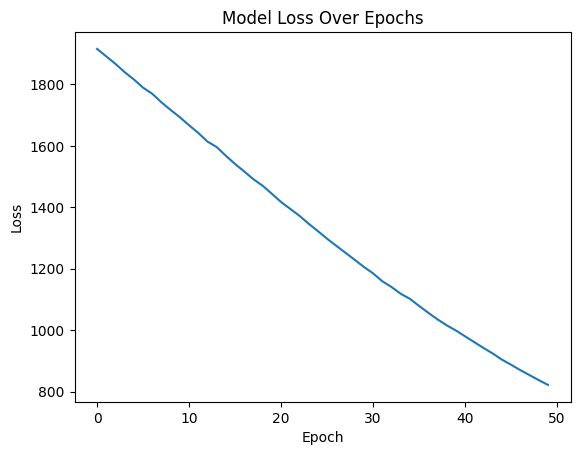

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


In [ ]:
history = model.fit(
    x=[X_train, y_train, input_length, label_length],
    y=ctc_targets,
    batch_size=4,
    epochs=50
)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - loss: 808.8322
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 35s 944ms/step - loss: 801.5529
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 918ms/step - loss: 783.9879
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 39s 874ms/step - loss: 785.7900
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 957ms/step - loss: 762.1125
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 872ms/step - loss: 743.7066
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 24s 959ms/step - loss: 754.5129
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 955ms/step - loss: 723.5925
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 925ms/step - loss: 717.3553
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 919ms/step - loss: 685.9487
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 900ms/step - loss: 692.7422
Epoch 12/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 911ms/step - loss: 656.8243
Epoch 13/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 23s 940ms/step - loss: 641.4127
Epoch 14/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 915ms/step - loss: 646.0857
Epoch 15/50
25/25 

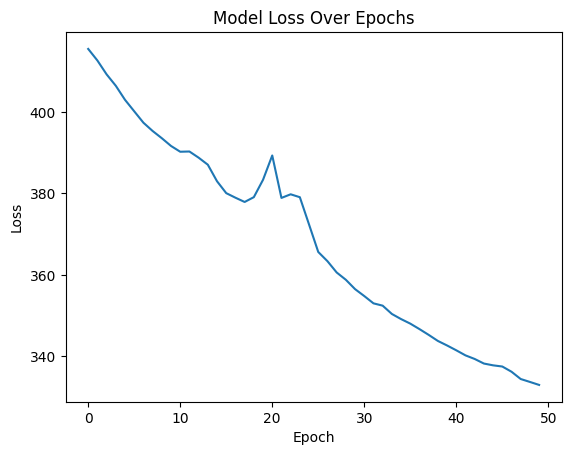

In [35]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


In [ ]:
history = model.fit(
    x=[X_train, y_train, input_length, label_length],
    y=ctc_targets,
    batch_size=4,
    epochs=50
)

Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 539ms/step - loss: 224.0789
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 14s 538ms/step - loss: 227.4179
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 532ms/step - loss: 228.6786
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 13s 514ms/step - loss: 223.9492
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 457ms/step - loss: 217.3069
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 518ms/step - loss: 217.4984
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 15s 586ms/step - loss: 226.0910
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 19s 520ms/step - loss: 216.9766
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 488ms/step - loss: 217.9878
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 515ms/step - loss: 210.9338
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 477ms/step - loss: 219.5630
Epoch 12/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 12s 460ms/step - loss: 223.6572
Epoch 13/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 22s 518ms/step - loss: 217.4592
Epoch 14/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 20s 482ms/step - loss: 224.0990
Epoch 15/50
25/

**Phase 6: Deployment and Inference**

This step involves:

Saving the trained model.

Building an inference pipeline to:

Load an audio file (or stream from mic in real time),

Extract MFCC features,

Run prediction using the trained model,

Decode the output into text.

(Optional): Wrap it into a simple app or script.



1. Save the Trained Model

In [36]:
model.save("/content/drive/MyDrive/RealTime-ASR-Project/models/asr_ctc_model.h5")


In [37]:
# Save only the prediction model (input to Dense layer)
prediction_model.save("/content/drive/MyDrive/RealTime-ASR-Project/models/predict_model.h5")


2. Load and Use the Model for Inference

In [38]:
for layer in model.layers:
    print(layer.name, layer.input_shape if hasattr(layer, 'input_shape') else 'No shape')


input_data No shape
masking No shape
bidirectional No shape
dense No shape
labels No shape
input_length No shape
label_length No shape
ctc No shape


3. Make Predictions on New Audio

In [40]:
from tensorflow.keras.models import Model

# Get model input and output directly
input_tensor = model.inputs[0]  # This is the actual audio input: (None, 485, 13)
output_tensor = model.get_layer('dense').output  # Final softmax logits (before CTC)

# Build prediction model
predict_model = Model(inputs=input_tensor, outputs=output_tensor)
predict_model.save("/content/drive/MyDrive/RealTime-ASR-Project/models/predict_model_clean.h5")
print("✅ Prediction model saved successfully.")


✅ Prediction model saved successfully.


In [59]:
global model
if model is None:
    model = ensure_model()


In [60]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
import tensorflow as tf
import numpy as np
import os

# Path where model was saved in SavedModel format (not .h5)
savedmodel_save_path = "/content/drive/MyDrive/RealTime-ASR-Project/models/predict_model_savedmodel"

# Input shape must match training input shape (from your MFCC preprocessing)
expected_time_steps = X_train.shape[1]
input_features = X_train.shape[2]

# Input layer for the wrapper model
input_layer_for_loading = Input(shape=(expected_time_steps, input_features), name='input_for_tfsmlayer')

# Wrap the SavedModel using TFSMLayer
tfsmlayer = tf.keras.layers.TFSMLayer(savedmodel_save_path, call_endpoint='serving_default')(input_layer_for_loading)

# Create the full wrapper model
loaded_predict_model = Model(inputs=input_layer_for_loading, outputs=tfsmlayer)
print("✅ Loaded wrapped prediction model.")

# Summary
loaded_predict_model.summary()


TypeError: Exception encountered when calling TFSMLayer.call().

[1mCould not automatically infer the output shape / dtype of 'tfsm_layer_5' (of type TFSMLayer). Either the `TFSMLayer.call()` method is incorrect, or you need to implement the `TFSMLayer.compute_output_spec() / compute_output_shape()` method. Error encountered:

Binding inputs to tf.function failed due to `too many positional arguments`. Received args: (<tf.Tensor 'Placeholder:0' shape=(None, 905, 13) dtype=float32>,) and kwargs: {} for signature: (*, input_data: TensorSpec(shape=(None, 485, 13), dtype=tf.float32, name='input_data')) -> Dict[['output_0', TensorSpec(shape=(None, 485, 29), dtype=tf.float32, name='output_0')]].
Fallback to flat signature also failed due to: Tensor Tensor("Placeholder:0", shape=(None, 905, 13), dtype=float32) is not compatible with the shape this function was traced with. Expected shape (None, 485, 13), but got shape (None, 905, 13).

If you called get_concrete_function, you may need to pass a tf.TensorSpec(..., shape=...) with a less specific shape, having None on axes which can vary.[0m

Arguments received by TFSMLayer.call():
  • args=('<KerasTensor shape=(None, 905, 13), dtype=float32, sparse=False, name=input_for_tfsmlayer>',)
  • kwargs={'training': 'False'}

Prediction based


In [61]:
import numpy as np
import tensorflow.keras.backend as K

# 1. Predict logits from the model
logits = loaded_predict_model.predict(X_train[:5])  # You can replace this with any input

# Access the output tensor from the dictionary
prediction_output = logits['output_0']

# 2. Compute sequence lengths (all are 485 in your case)
# Use the shape of the prediction_output tensor
input_lengths = np.ones(prediction_output.shape[0]) * prediction_output.shape[1]

# 3. Decode using greedy CTC decoder
# Pass the prediction_output tensor to ctc_decode
decoded, _ = K.ctc_decode(prediction_output, input_length=input_lengths, greedy=True)

# 4. Convert tensor to numpy
# The output of K.ctc_decode is a list of tensors, take the first one
decoded_sequences = K.get_value(decoded[0])

# 5. Convert integer sequences to text using your int_to_char
def decode_to_text(sequence, int_to_char):
    return ''.join([int_to_char[i] for i in sequence if i != -1])

# Assuming you have `int_to_char` dict (index to character mapping)
for i, seq in enumerate(decoded_sequences):
    decoded_text = decode_to_text(seq, int_to_char)
    print(f"Sample {i + 1}: {decoded_text}")

NameError: name 'loaded_predict_model' is not defined

In [ ]:
pip install streamlit librosa tensorflow matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 71.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 6.5 MB/s eta 0:00:00


In [ ]:
!pip install streamlit pyngrok


In [ ]:
!pip install pyngrok streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 59.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 50.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 7.4 MB/s eta 0:00:00


Auth Token : 2x6EZJ5auF56ZjDwfbkHeHpIboM_qnG1ZCYD1qsGiszLLSo7

In [ ]:
import os
from pyngrok import ngrok
import subprocess
import time
from getpass import getpass # Import getpass to securely input the token

# 1) Point to your Streamlit script
app_path = "/content/drive/MyDrive/RealTime-ASR-Project/app/streamlit_app.py"

# 2) Get your ngrok authtoken securely
print("Please enter your ngrok authtoken:")
NGROK_AUTH_TOKEN = getpass() # Use getpass to hide the input
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# --- ADD THIS STEP ---
# Attempt to disconnect any existing tunnel before killing processes
# This can sometimes be more reliable than just killing processes immediately
try:
    # Get a list of existing tunnels
    tunnels = ngrok.get_tunnels()
    for tunnel in tunnels:
        print(f"Disconnecting existing tunnel: {tunnel.public_url}")
        ngrok.disconnect(tunnel.public_url)
    # Wait a moment for disconnect to complete
    time.sleep(2)
except Exception as e:
    print(f"Could not disconnect existing tunnels (this might be expected if none are running): {e}")
# --- END OF ADDITION ---


# 3) Kill any existing tunnels & start a new one on port 8501
# We keep ngrok.kill() as a fallback, but disconnecting first is preferred.
ngrok.kill()

try:
    public_url = ngrok.connect(8501, "http")
    print("👉 Streamlit URL:", public_url)

    # 4) Launch Streamlit in the background
    #    --server.port 8501 binds to the tunnel port
    cmd = f"streamlit run {app_path} --server.port 8501 --server.headless true"
    subprocess.Popen(cmd.split(), stdout=subprocess.PIPE, stderr=subprocess.PIPE)

    # 5) Give Streamlit a few seconds to boot
    time.sleep(5)

except PyngrokNgrokError as e:
    print(f"Failed to start ngrok tunnel. Error: {e}")
    print("Please check your ngrok dashboard (https://dashboard.ngrok.com/agents) for active sessions.")
    print("You may need to manually stop existing sessions or wait for them to expire.")

Please enter your ngrok authtoken:
··········


ERROR:pyngrok.process.ngrok:t=2025-05-15T07:23:32+0000 lvl=eror msg="failed to reconnect session" obj=tunnels.session err="authentication failed: Your account is limited to 1 simultaneous ngrok agent sessions.\nYou can run multiple simultaneous tunnels from a single agent session by defining the tunnels in your agent configuration file and starting them with the command `ngrok start --all`.\nRead more about the agent configuration file: https://ngrok.com/docs/secure-tunnels/ngrok-agent/reference/config\nYou can view your current agent sessions in the dashboard:\nhttps://dashboard.ngrok.com/agents\r\n\r\nERR_NGROK_108\r\n"
ERROR:pyngrok.process.ngrok:t=2025-05-15T07:23:32+0000 lvl=eror msg="session closing" obj=tunnels.session err="authentication failed: Your account is limited to 1 simultaneous ngrok agent sessions.\nYou can run multiple simultaneous tunnels from a single agent session by defining the tunnels in your agent configuration file and starting them with the command `ngrok st

NameError: name 'PyngrokNgrokError' is not defined